# Build your own GPT

> This notebook was inspired by the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video lesson from [Andrej Karpathy](https://karpathy.ai/).


**GPT** is, at its core, a **generative language model** for text generation.
It is a particular type of neural network with an optimization procedure on top that pushes it to answer questions or to perform tasks that **satisfy the prompts** us humans provide.

In this notebook we will build together such kind of network, although at a much smaller scale and slightly simplified.

We will first build a simpler model, in Part 1, to understand what a language model essentially does, without the complications that state-of-the-art techniques bring upon themselves.



## Part 1: The G in GPT
In this first part we will approach the topic of language models for text generation with a simple but very instructive model: the **Bigram**.

**We will learn:**
- How to transform text in a way that is suited for a ML model
- How to break the data down into chunks for training the model
- What is a generative language model such as the Bigram.


### To ensure reproducibility

In [ ]:
import torch
torch.manual_seed(47)
torch.mps.manual_seed(47)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)

import numpy as np
np.random.seed(47)

import random
random.seed(47)

### From Shakespeare to numbers (and back)

To start, we need a healthy amount of text to feed our model.

Let's then download the **tinyshakespeare** dataset, which will provide a text with a very peculiar structure, syntax and topics.

In [ ]:
!wget -P data https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [ ]:
# read it in to inspect it
with open('data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("Number of characters in the dataset: ", len(text))

In [ ]:
# let's look at a sample
print(text[2000:3000])

Let's break down the text into its atomic components, the characters:

In [ ]:
# unique characters that occur in this text, i.e. its "alphabet"
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(f"Number of unique characters: {vocab_size}")

Characters from the english alphabet are easy enough for us to read, but ML models speak the language of numbers.

Indeed, in an operation called *tokenizing* we encode each character into numbers, called **tokens**:

In [ ]:
class Tokenizer:
    def __init__(self, chars: list[str]):
        # create a mapping from characters to integers and viceversa
        self.char_to_token = {ch: i for i, ch in enumerate(chars)}
        self.token_to_char = {i: ch for i, ch in enumerate(chars)}

    def encode(self, string: str):
        # encoder: take a string, output a list of integers
        return [self.char_to_token[ch] for ch in string]

    def decode(self, tokens: list[int]):
        # decoder: take a list of integers, output a string
        return ''.join([self.token_to_char[token] for token in tokens])

In [ ]:
tokenizer = Tokenizer(chars)

In [ ]:
print(tokenizer.encode("xtream"))
print(tokenizer.decode(tokenizer.encode("xtream")))

This is a very simple and arbitrary tokenizer.

There are more advanced ones like Google's [sentencepiece](https://github.com/google/sentencepiece) or OpenAI's [tiktoken](https://github.com/openai/tiktoken), actually used in GPT.

Some of these tokenizers don't actually encode characters, but rather syllables or words: it can be more useful or more efficient, but for our purposes we stick with the simpler character encoding.

![tokenization](img/01_tokenization.png)

Let's see how our dataset looks when tokenized:

In [ ]:
# let's now encode the entire text dataset and store it into an array
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[2000:3000]) # this is how the same excerpt as before looks now

For example, 0 and 1 respectively encode the blank and newline character.

### Splitting into training and validation

Now we need to perform a standard operation in ML: **splitting the dataset**.

Basically, a so-called *supervised learning* model like the one we want to build acts kind of like a student at school: picture a math class in which students learn how to, say, solve polynomial equations by following the teacher at the blackboard showing them examples and solving techniques.

Then, the day of the final exam, they are asked to do the same and get evaluated.

Of course, the teacher will ask to solve different examples than those that were solved during the lessons, otherwise students could just memorize those particular solutions and not be able to do anything else.

Since the teacher wants to make sure that students **actually learned** how to solve any equation of the type that was explained to them, they will provide new unseen examples during the exam.

This is exactly why we will divide the dataset into two chunks called **train** and **validation**, which will serve as follows:
- train will be shown to the model during its learning phase,
- validation will only be shown afterwards, as the final exam.

In [ ]:
# Let's split up the data into training and validation
n = int(0.9*len(data)) # first 90% will be train, rest is validation
train_data = data[:n]
val_data = data[n:]

### Blocks of text

But how will the model learn from the train portion of our dataset?

The answer is by randomly selecting small-sized chunks, or **blocks**, of text and corresponding **targets** which are the characters that follow each block.

The model will iteratively try to predict a target for each block, and at every iteration its internal structure will change with the purpose of improving the following predictions.

We need to set a parameter controlling the size of these blocks:

In [ ]:
block_size = 8
train_data[:block_size+1]

### Many samples from a block

If you think about it, a single block has actually **many examples packed inside**, from which the model can learn: since the block size is somewhat arbitrary, when the model picks a block it might as well consider all the sub-blocks of smaller size.

Another advantage of extracting these sub-examples of shorter length is that they allow our model to be able to start predicting the next character with as little as one observed character, since it learned to do so at training phase.

Indeed, let's look at how a single block of size 8 can actually provide 8 training samples to our model.

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
print(f"block is {x.numpy()}")
print(f"targets are {list(y.numpy())}")
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when training sample is {context.numpy()} the target is: {target.numpy()}")

Notice that, as it is customary, we call x the input examples and y the targets, i.e. the single characters following the examples.

### Going into the 3rd dimension: training batches

Another parameter we need to set is **batch size**.

Complex models like neural network run much faster on GPUs, whose architecture is really good at parallelizing computation on data structures called **tensors**.

A tensor is simply a generalization of a matrix, i.e. a n-dimensional *box* of numbers.

This means that it is often more convenient to stack multiple examples in a batch allowing the GPU to run them in parallel.

In our case, this means stacking multiple 1D vectors (the examples) into a 2D matrix.

![tensor](img/02_tensor.png)

Let's define a way to fetch a number of samples at random and stack them into a batch tensor, and do the same with the corresponding targets:

In [ ]:
batch_size = 4 # how many independent sequences will we process in parallel
block_size = 8 # the maximum context length for predictions

def get_batch(split):
    # generate a batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print(f'{batch_size} blocks of size {block_size}:')
print(xb.shape)
print(xb)
print(f'{batch_size} lists of {block_size} targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # block dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when training sample is {context.tolist()} target is: {target}")

In [ ]:
print(xb, "\n", yb)

### Your first language model: the Bigram

Now we are ready to build our language model: we will define a simple **Bigram**.

A Bigram model simply stores a number for each couple of characters into a table, called *token embedding table*.

When given a character, the Bigram model fetches from this table the row corresponding to this character and returns it.

The name of the table stems from the fact that associating a whole row of numbers to a given character can also be expressed as representing that character by those many numbers, or equivalently *embedding* it into a high-dimensional space.

As for the actual meaning of the table, the row (or *logits* vector) associated to a given character will be interpreted by the bigram as a set of probabilities for each character to be the next one:

| |a|b|c|d|...|
|---|---|---|---|---|---|
|a|0.001|0.02|0.06|0.03|...
|b|0.02|0.009|0.07|0.02|...
|c|0.011|0.01|0.03|0.004|...
|d|0.004|0.003|0.09|0.01|...
|...|...|...|...|...|...

![bigram](img/03_bigram.png)

We can define such an embedding table in `torch` with an `Embedding` object:

In [ ]:
import torch.nn as nn
embedding_table = nn.Embedding(3, 2)

Then, calling the table with an index will return the corresponding row:

In [ ]:
embedding_table(torch.tensor(0))

As you can see, the table is actually initialized with random values unless we specify otherwise.

We are now ready to define the model, endowing it with an embedding table like the one we've seen just now.

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets):

        # idx and targets are both (B,T) tensor of integers
        # at each token the output for the next one is a row from the probability table
        logits = self.token_embedding_table(idx) # (B,T,C)

        return logits

m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

You can see that, given a batch example/target `xb, yb`, the model outputs 65 probabilities for each example extracted from the batch (that has size 4 x 8).

Side note, we are using the PyTorch framework with its syntax: here, `forward` actually means that the model is called on its input to produce its output, which is commonly referred as a `logit` meaning an unnormalized, unconstrained value that still needs to be transformed into an actual probability (which we'll do later on)


### Evaluating the model

In order to evaluate the predictions we need to define a **loss function**, measuring how wrong or far away the prediction is from the target.

We will use the [*cross entropy*](https://en.wikipedia.org/wiki/Cross_entropy), also called *log loss*, a common choice in the field of natural language processing.

It is defined as:


$$
H(p, q) = \sum_x p(x) \log q(x)
$$

Where $x$ are the possible prediction values, $p(x)$ is the true value (so that $p(x)=1$ if $x=x_{true}$ and $p(x)=0$ otherwise) and $q(x)$ the probabilities predicted by the model.


Let's then rewrite our model inserting a step that computes and returns the loss of a given example:

In [ ]:
from torch.nn import functional as F

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets):

        logits = self.token_embedding_table(idx) # (B,T,C)

        # a bit of tensor manipulation is necessary to get the right shapes and sizes
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

What does this loss value tell us?

Well let's pick the dumbest scenario, in which the model just picks the next character completely at random: this equates to a completely uniform logits vector, and the loss would be equal to roughly 4,17.

In [ ]:
B, T, C = logits.shape
uniform_logits = torch.ones(logits.shape)
F.cross_entropy(uniform_logits.view(B*T, C), yb.view(B*T))


The model is doing worse than that!

But let's not worry about the quality of the output yet, and define instead a way for the model to actually generate text based on its embedding table.

We define a `generate` method that acts iteratively as follows:
  - It calls `forward`;
  - At each call, the returned logits are transformed into probabilities*;
  - The probabilities are then used to sample the next character;
  - This is appended to the block and passed again to `forward`, in a *bootstrapping* kind of way.

*again, don't worry about this transformation just yet.

We actually need to tweak the `forward` method a bit, because we want to call it without any targets and without computing any loss.

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # (B, C)
            # apply softmax transformation to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # concatenate sampled index to the sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)

Finally, in order to visualize the generated output we need to turn it back into text, using our tokenizer to decode it.

In [ ]:
print(tokenizer.decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

### Model workout

Surprise, the outcome is complete garbage!

That's because we still need to *actually train* the model by iteratively call it on batch examples and then update its parameters, which in our case are the entries of the embedding table.

Let's use a PyTorch optimizer that does exactly this: instantiated with the model parameters, it acts after every model iteration by using the loss in order to compute the new and hopefully improved parameters.

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(1, 20000): # more steps=better training (up to a certain amount)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    if steps % 1000 == 0:
      print(f"Step {steps}:")
      print(f"loss = {loss.item():.3f}")
    optimizer.step()

In [ ]:
print(tokenizer.decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

The final loss value is significantly lower, indicating that the model tends to predict the next character better than before.

The output text is... well, a bit better right?

If you squint your eyes it almost seems like a plausible old english screenplay.
You see words of reasonable length, punctuation at the end of the lines, names in all caps denoting who's talking.

The text of course is still meaningless and there are characters that are clearly out of place; maybe we can do better?

### Recap

- To feed text into a Language model, we need to first turn it into numbers with **tokenization**.
- We then need to split our data into training and validation, as it is common when training any statistical model.
- We also split our data into blocks: the model will see one block and try to predict the character next to it.
- With a simple but effective trick, we get more training samples from a single block.
- We also structure our data into batches, which makes training more optimized.
- When the data is ready, we define the **bigram**: a model which incorporates a probability table that tells us the likelihood of all characters as following any other one.
- With classical ML techniques we can feed the training data into the bigram and try it on the test data.
- The trained Bigram is able to generate infinite text starting from as low as 1 initial token using the probabilities that it learned.

## Part 2: The T in GPT



**We will learn:**
- How to exploit more information than just the last token
- The mechanism that allows the model to learn such information
- The neural network architecture that empowers the attention mechanism

### Using more information


Let's go back to how the model works and actually think about it: we are feeding the model all these blocks at once to build a token embedding table, but at generation phase we are just using the last character we have to predict the next.

Why don't we use more information than just the last token to generate text?
Consider the following bit (kindly provided by ChatGPT):


> Pat: "I just read that in the desert, **dates are essential for survival.**"

>  Alex, overhearing just the last part in bold: "You need to go on dates to survive in the desert?"

> Pat: "No, I meant dates, the fruit, not social outings!"

Our model is just like Alex: when it is asked to continue a text, it has only "heard" the last character and ignores all the previous context.

Indeed, it would be better if we could allow the model to actually use the full sequence in the block instead, encoding more complex probabilities.


### The simplest way to aggregate information: bag of words

The problem is that in the end we still need to boil down all the block information into a single probability distribution for the next character, though, and this is not trivial.

What can we do, then? The first kind of aggregation that comes to mind is a simple average, also called a *bag of words*.

Let's spell out the procedure:

Consider a batch with the same size as before: its shape will be given by the tuple (B, T, C) where B is the batch size, T is the block size (also "time" dimension, if you imagine that we are moving through the block in time) and C is the amount of *channels*, which are the numbers associated to each token.

We only have a single number for each token, i.e. the result of its tokenisation, so C=1 (for now!).

In [ ]:
# for example:
B,T,C = 4,8,1 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

In the simple Bigram, when we were predicting the nth token we only considered the (n-1)th; now, let's instead average all the preceding 1st, 2nd, ..., (n-1)th:

In [ ]:
# Computing partial averages up to t for each t
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [ ]:
x[0]

In [ ]:
xbow[0]

You can see how the n-th row of `xbow` contains the information in `x` *averaged up to the nth row*.

This means that by using this technique, at each time step in the sequence of text, the model possesses some aggregate information about what was contained in the text block up until that time step.

Is this useful?

Not really! It's not like you can predict what I'll say next by turning the words I've said so far into numbers and then just making an average of them.

Still, bear with this procedure.



### And now, a few mathematical tricks!

Making tons of partial averages in for loops is quite cumbersome and computationally expensive.

Since we are working with matrices and tensors, it'd be great if this aggregation could be easily done via some tensor operation, say a multiplication.

Wouldn't you look at this! it can be done indeed:


In [ ]:
# how matrix multiplication can be used for a weighted average
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

in this example `b` represent our original `x`, and `c` is the bag-of-words `xbow`.

The *lower triangular* matrix `a` does exactly the partial averages as before.

Coming back to our case, let's see how this all works:

In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
wei

In [ ]:
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
xbow2[0]

But we are not satisfied with this! we want to change how the matrix `wei` is defined.

Why, you ask?

Consider the following:

In [ ]:
# version 3: use Softmax
wei = torch.zeros((T,T))
wei

In [ ]:
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

In [ ]:
wei = F.softmax(wei, dim=-1)
wei

In [ ]:
xbow3 = wei @ x
xbow3[0]

`xbow3` is yet again equal to its predecessors.

Differently than before, though,  the multiplying matrix wei is obtained from a triangular matrix of zeroes and infinities to which we apply the [softmax function](https://en.wikipedia.org/wiki/Softmax_function), which squashes all numbers into the \[0, 1\] interval and normalizes them, making a probability distribution out of them and turning `wei` in exactly the same matrix we defined before.

$\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$

Yes, this is exactly the same transformation we applied to the output of the Bigram: it is much easier to let the model outputs lie unconstrained in \[-∞, ∞\] and then just force them as a whole to turn into a probability distribution.

![softmax](img/04_softmax.jpeg)

Why did we have to make it harder, you ask?

Because we can now interpret the steps with which we obtain the multiplying matrix wei as follows:

- the first matrix of zeroes represents a **uniform starting point**;
- applying the infinities mask imposes that we **cannot use information from the future**, i.e. from characters that follow the one we are at;
- applying the softmax imposes that **every row should be a probability distribution**, so that wei acts as a weighted average of all previous tokens for each time step (=each row).

Maybe you can now see that we are finally able to decide how much each token n considers each predecessor token m by just changing the (n, m)-th entry of that first matrix of zeroes!

Look what happens if we arbitrary change an element of `wei`, let's say the 7th row, 2nd column.

Bear in mind that the (n, m) element of `wei` is supposed to measure how much the nth token in a block considers the mth when averaging all its predecessors.

In [ ]:
wei = torch.zeros((T,T))
wei[6, 1] = torch.Tensor([2]) # increased
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)

In [ ]:
wei = F.softmax(wei, dim=-1)
mod_xbow = wei @ x
mod_xbow[0]

In [ ]:
xbow2[0]

By comparing the modified bag of words with before, we see that the only difference is indeed in the 7th row.


In [ ]:
print(f"Before: {xbow2[0][6].numpy()}")
print(f"After: {mod_xbow[0][6].numpy()}")

At that position, the token has now different information values: indeed, while averaging it used much more of the 2nd token:

In [ ]:
print(f"Weights for the 7th token: {wei[6].numpy().round(2)}")

and, since the information there was negative:

In [ ]:
print(f"2nd token: {x[0][1].numpy()}")

the final outcome has significantly decreased.

### Attention is all we need

![attention](img/05_attention.jpeg)

We are ready to define the most fundamental concept: (self-)attention.

The idea is that the model should be able to learn the multiplying matrix `wei` that we have seen before, which represents how each token considers each other preceding token.

Crucially, though, **the model does not learn the weights directly**; it actually learns a couple of vectors for each token, and the weights matrix is obtained by multiplying those vectors by means of a scalar product.

Consider a couple of tokens `a` and `b`, and two vectors called **key** and **query** for each of them: `key_a`, `key_b`, `query_a`, `query_b`.

In [ ]:
key_a = torch.tensor([1, 2, 3])
key_b = torch.tensor([4, 5, 6])

query_a = torch.tensor([7, 8, 9])
query_b = torch.tensor([6, 5, 4])

Then, the "ab" and "ba" entry of the weights matrix are respectively:

In [ ]:
wei_ab = query_a @ key_b
wei_ba = query_b @ key_a

In [ ]:
wei_ba

In [ ]:
wei_ab



Why bothering to learn two vectors for each token instead of a matrix (i.e. a single number for each token pair)?

Imagine keys and queries as, respectively, the information a token has and the one it is it looking for: **when the key of a token is similar to the query of another, they have found each other** and their affinity is strong.

Mathematically, by computing the scalar product we obtain exactly what we need: the product of two vectors measures how much they are aligned to each other (it is equal to 1 if they are parallel, 0 if they are perpendicular).

The wei matrix, finally, is computed as having in its (n, m) entry the dot product between the query of the n-th token and the key of the m-th one, signifying how "interesting", or "affine", the n-th token finds the m-th one.


We talk about an **attention mechanism**, or *head*, of size n (in the diagram below it is 3) as a module containing:
- a *key* of size n for each token, i.e. at any time step and for any batch element;
- a *query* of size n for each token, i.e. at any time step and for any batch element;
- a *value* of size n for each token, i.e. at any time step and for any batch element.

Think as the value of a token as the information that it brings to the final computation: It is maybe a bit hard to understand what it actually means, and you can also just think of it as another layer of abstraction and parameters that allow the model to interpret each token with more flexibility.


![attention_mechanism](img/06_attention_mechanism.png)

In [ ]:
# version 4: self-attention
B,T,C = 4,8,1 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head of size H perform
H = 3
key = nn.Linear(C, H, bias=False)
query = nn.Linear(C, H, bias=False)
value = nn.Linear(C, H, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
wei =  q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x) # (B, T, H)
out = wei @ v # (B, T, H)
#out = wei @ x

out.shape

Let's take a look at the wei matrix for the first batch element and see if we can interpret it right.

In [ ]:
wei[0]

Before self-attention we had a matrix whose rows contained uniform distributions, indicating that each token would consider itself and all previous token as equal for the computation of the output of the model.

Now, all values are different: given the last row, for example, in the current situation the last token has a higher consideration towards the 4th and 7th token than towards all the other ones; this means that the output for the next character will largely depend upon those tokens.

But what about the actual output of the attention head?

In [ ]:
out[0]

For each token in the block we get a vector (of size = head_size) that contains all information the model has extracted from observing the sequence up to that token.

This is potentially a huge improvement over the Bigram case, where from each token we would just extract the probabilities of the next one, without considering any other token or even in what position the token was.

Now that we appreciated how attention works, let's build an attention head module.

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_channels, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_channels, head_size, bias=False)
        self.query = nn.Linear(n_channels, head_size, bias=False)
        self.value = nn.Linear(n_channels, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (B, T, C)
        # output of size (B, T, H)
        B, T, C = x.shape
        k = self.key(x)  # (B, T, H)
        q = self.query(x)  # (B, T, H)
        # compute attention "affinities"
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # (B, T, H) @ (B, H, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # weighted aggregation of the values
        v = self.value(x)  # (B, T, H)
        out = wei @ v  # (B, T, T) @ (B, T, H) -> (B, T, H)
        return out

### Extra remarks on attention

How an attention head is actually used requires adding more layers and parameters, i.e. building a fully-fledged transformer-based neural network such as GPT.

- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much

### The transformer architecture

As it turns out, the attention mechanism is at the heart of neural networks architectures that are called **transformers**.

Indeed, in our case a transformer is nothing more than a number of parallel attention heads whose outputs are integrated in a single structure at the end.

So let's start with parallelizing multiple attention heads:

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_channels, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_channels, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

The attention heads need to be integrated with each other and by some other layers in order to fully capture their power and expressivity: below you can see a diagram of GPT's approximate architecture on the left, with a zoom of the transformer block on the right.

![transformer](img/07_transformer.png)

The diagram looks really messy and complicated, having many more steps other than the attention mechanisms.

Actually, though, all those other steps are standard general-purpose neural network components; we won't go into the details on their implementation or their motivation, as it can get quite complicated.

If this all seems quite random or unjustified to you, bear in mind that modern neural networks often rely on breakthroughs and innovations that are not even fully understood yet.

Researchers often manage to improve architectures by adopting heuristics, intuitive reasoning or even brute force.

When a change brings better performance, it just propagates forward in future generations of that architecture, while researchers try to understand the reason behind the improvement.

Just for fun, have a look at the family tree of LLMs, taken from [J. Yang et al., Harnessing the Power of LLMs in Practice: A Survey on ChatGPT and Beyond
 ](https://arxiv.org/pdf/2304.13712.pdf)

![llm_genealogy](img/08_llm_genealogy.png)

Here we define all other layers in the transformer block (the upper half, after the multiple attention heads).

We can group them all into a structure which we'll call FeedForward.

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linear so-called "activation function" """

    def __init__(self, n_channels, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_channels, 4 * n_channels),
            nn.ReLU(),
            nn.Linear(4 * n_channels, n_channels),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

Without further ado, then, here is our transformer block.

In [ ]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_channels, n_head, block_size, dropout):
        # n_channels: channels dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_channels // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_channels, block_size, dropout)
        self.ffwd = FeedForward(n_channels, dropout)
        self.ln1 = nn.LayerNorm(n_channels)
        self.ln2 = nn.LayerNorm(n_channels)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

### Recap
- When predicting text generation, we want to exploit more information than just the last/current token, i.e. a **context**.
- The simplest way to do so is using any number of previous tokens, and just averaging their value.
- The average can be seen as a product with a matrix of uniform weights; if we allow them to change instead, we can let a ML model learn the best values.
- The attention mechanism is just this: the model learns *key* and *query* vectors for each token, and performs a scalar product on them to compute the weights for each token pair.
- the attention mechanism sits at the core of the **transformer** architecture.

## Part 3: Embeddings and final architecture

**We will learn:**
- Some tricks to improve the generative performance
- how to train and produce text generation with the full GPT architecture

### Embeddings

The last thing we need to talk about before putting all the pieces together are the initial steps in the GPT diagram above: the **embeddings**.

Until now, all computational layers act in a chain that starts with the encoded numerical values which we called tokens.

This is fine, but it means that we are asking the model to extract meaningful information about a character starting from a single number, its token, which was of course arbitrarily associated to it.

It would be better if there was an extra layer, mapping all tokens into a bigger space, with many empty slots that the model can fill in containing arbitrary information to work on.

This is why we defined all our tensor with an additional dimension, which we called **channels**, and we temporarily set it to 1.

Mathematically, we say that the single token gets *embedded in a higher-dimensional space*; we just need to choose the dimension (the number of slots allocated to each token).

A higher dimension means more parameters and improved possibility of storing information about a token (more *expressivity*, in ML jargon), but it also means more computational complexity.


Let's try with a small embedding, of dimension 8:

In [ ]:
token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=8)
token_embedding_table.weight

Initialized at random, this is just 8 numbers for each token that are learnable by the model.

Ideally, having 8 independent learnable numbers for each token will make it easier for the model to learn meaningful information about it.

Indeed, the model can potentially use each slot for a different feature or pattern to learn.

Look at this word embedding, for example:

![embedding](img/09_embedding.jpeg)

Each dimension has been given a meaning, so that semantic information can be learned and stored by the model.

Finally, but crucially, we want to also encode the position of a token in the sequence.
This **positional embedding** works exactly the same way as before, but it encodes the relative position of a token instead of its value:

In [ ]:
position_embedding_table = nn.Embedding(num_embeddings=8, embedding_dim=16)
position_embedding_table.weight

In the example above, the 16x8 embedding table would allow the model to arbitrarily fill 16 slots for each position in a 8-sized block.

### The final architecture

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # the maximum context length for predictions
max_iters = 1800 # how many iteration during training
eval_interval = 100 # how often to evaluate training
learning_rate = 3e-4
device = get_device()
eval_iters = 100
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------
class GPTLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, n_layer, n_head, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.vocab_size = vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[TransformerBlock(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=get_device()))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B * T, C), targets.view(B * T))

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

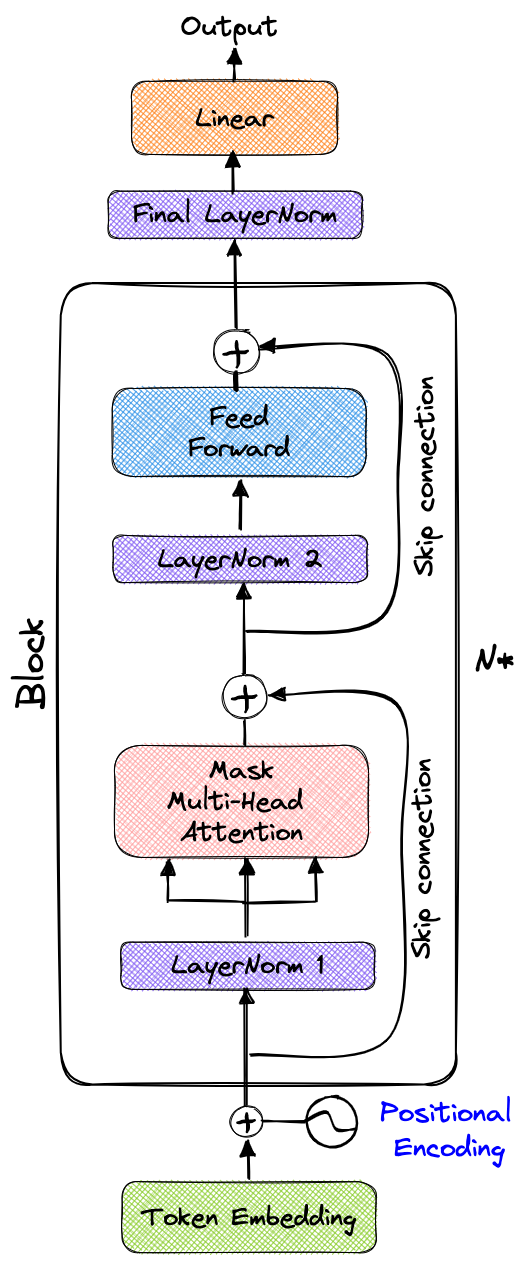

### Recap

- embeddings are the initial encoding layer that allows the model to learn semantic and positional information about tokens.
- multiple transformers get stacked and integrated with other standard NN modules to form the GPT architecture.

### Final training and prediction

In [ ]:
# data loading
def get_batch(data, block_size, batch_size, device):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for label, data in {"train": train_data, "val": val_data}.items():
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(data, block_size, batch_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[label] = losses.mean()
    model.train()
    return out

In [ ]:
model = GPTLanguageModel(vocab_size=vocab_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head, block_size=block_size, dropout=dropout)
model.to(device) # use GPU device if available
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
%%time
for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch(train_data, block_size, batch_size, device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

In [ ]:
%%time
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = tokenizer.decode(model.generate(context, max_new_tokens=2000)[0].tolist())
print(generated_text)

In [ ]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
with open('data/output.txt', 'w') as f:
    f.write(generated_text)

In [ ]:
import pickle

if not os.path.exists("model"):
    os.mkdir("model")

with open("model/model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)